# Relaxation Deferred Correction notebook

This notebook is an extension of the original [Relaxation Runge--Kutta Notebook](https://github.com/ketch/RRK_rr) provided by D. Ketcheson and H. Ranocha on the work of H. Ranocha, M. Sayyari, L. Dalcin, M. Parsani and D. I. Ketcheson on [Relaxation Runge--Kutta Methods: Fully Discrete Explicit Entropy-Stable Schemes for the Compressible Euler and Navier--Stokes Equations](https://doi.org/10.1137/19M1263480).

Here we use the Deferred Correction method as a Runge--Kutta method. The implementation of the Deferred Correction method as a Runge--Kutta method is included in [DeC.py](DeC.py) and explained in details in the work [Relaxation Deferred Correction Methods and their Applications to Residual Distribution Schemes ](https://arxiv.org/abs/2106.05005) by R. Abgrall, E. Le Mélédo, P. Öffner and D. Torlo.

# Setup

In [2]:
import os
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve, newton, brentq, bisect
from DeC import *

# line cycler adapted to colourblind people
from cycler import cycler
colourblind_cycler = (cycler(color=['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']) +
                      cycler(linestyle=['-', '--', '-.', ':', "-", "--", "-."]))
plt.rc("axes", prop_cycle=colourblind_cycler)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{newpxtext}\usepackage{newpxmath}\usepackage{commath}\usepackage{mathtools}")
plt.rc("font", family="serif", size=14.)
plt.rc("savefig", dpi=200)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)


from nodepy import *

# http://people.math.sfu.ca/~jverner/RKV87.IIa.Robust.00000754677.081208.FLOAT40OnWeb
ssp2 = rk.loadRKM('SSP22').__num__()
ssp3 = rk.loadRKM('SSP33').__num__()
rk4 = rk.loadRKM('RK44').__num__()


decEqRKs =[]
decGLBRKs =[]
for order in range(2,10): 
    A,b,c=compute_RK_from_DeC(order-1,order,"equispaced") # subtimesteps, iterations, nodetype{"equispaced","gaussLobatto"}
    decEqRKs.append(rk.ExplicitRungeKuttaMethod(A,b))
    decEqRKs[order-2].name="DeC%dEq"%(order)
    A,b,c=compute_RK_from_DeC(np.int(np.ceil(order/2.)),order,"gaussLobatto") # subtimesteps, iterations, nodetype{"equispaced","gaussLobatto"}
    decGLBRKs.append(rk.ExplicitRungeKuttaMethod(A,b))
    decGLBRKs[order-2].name="DeC%dGLB"%(order)

dec3 = decEqRKs[1]

dec4_equi = decEqRKs[2]

dec4_galo = decGLBRKs[2]
methods = [ssp2, ssp3, dec3, rk4, dec4_equi]
method_labels = ["SSPRK(2,2)","SSPRK(3,3)","DeC(3)", "RK(4,4)","DeC(4)"]


os.system("mkdir Plots")


def compute_rest(rkm, dt, f, eta, deta, w0):
    """Compute the term which is set to zero by relaxed explicit Runge-Kutta methods 
    for general (convex) functionals."""
    s = len(rkm)
    y = np.zeros((s, len(w0))) # stage values
    F = np.zeros((s, len(w0))) # right hand sides
    for i in range(s):
        y[i,:] = w0.copy()
        for j in range(i):
            y[i,:] += rkm.A[i,j]*dt*F[j,:]
        F[i,:] = f(y[i,:])
    
    direction = dt * sum([rkm.b[i]*F[i] for i in range(s)])
    estimate = dt * sum([rkm.b[i]*np.dot(deta(y[i,:]),F[i]) for i in range(s)])
    r = lambda gamma: eta(w0+gamma*direction) - eta(w0) - gamma*estimate
    return r
    

def convex_relaxed_ERK(rkm, dt, f, eta, deta, w0, t_final, 
                       relaxed=True, method="brentq", tol=1.e-14, maxiter=10000, jac=False, newdt=True, 
                       debug=False, correct_last_step=True):
    """Relaxed explicit Runge-Kutta method for convex functionals. It is also possible to apply
    these schemes to general functionals. In that case, some root finding procedure have to be adapted
    slightly."""
    
    w = np.array(w0) # current value of the unknown function
    t = 0 # current time
    ww = np.zeros([np.size(w0), 1]) # values at each time step
    ww[:,0] = w.copy()
    tt = np.zeros(1) # time points for ww
    tt[0] = t
    relterms = np.zeros(0)
    b = rkm.b
    s = len(rkm)
    y = np.zeros((s, np.size(w0))) # stage values
    F = np.zeros((s, np.size(w0))) # stage derivatives
    max_gammam1 = 0.  # max(gamma-1) over all timesteps
    old_gamma = 1.0
    
    
    # Because of the scaling by gam, the time step which should hit t_final might be a bit too short.
    # In that case, accept this step as the last one in order to terminate the integration.
    while t < t_final and not np.isclose(t, t_final):
        if t + dt > t_final:
            dt = t_final - t
        
        for i in range(s):
            y[i,:] = w.copy()
            for j in range(i):
                y[i,:] += rkm.A[i,j]*dt*F[j,:]
            F[i,:] = f(y[i,:])
        
        if relaxed and ((not np.isclose(dt, t_final - t)) or correct_last_step):
            direction = dt * sum([b[i]*F[i,:] for i in range(s)])
            estimate = dt * sum([b[i]*np.dot(deta(y[i,:]),F[i,:]) for i in range(s)])

            r = lambda gamma: eta(w+gamma*direction) - eta(w) - gamma*estimate
            if debug:
                print('r(1): ', r(1))
            rjac= lambda gamma: np.array([np.dot(deta(w+gamma*direction), direction) - estimate])
            
            if rjac == False:
                use_jac = False
            else:
                use_jac = rjac
            
            if method == "newton":
                gam = newton(r, old_gamma, fprime=rjac, tol=tol, maxiter=maxiter)
                success = True
                msg = "Newton method did not converge"
            elif method == "brentq" or method == "bisect":
                # For convex functionals, additional insights are provided: There is exactly one root
                # and r is negative for smaller gamma and positive for bigger gamma. Thus, we can use
                left= 0.9 * old_gamma
                right = 1.1 * old_gamma
                while r(left) > 0:
                    right = left
                    left *= 0.5
                while r(right) < 0:
                    left = right
                    right *= 2.0
                # For general functionals, we might need to use omething like:
                #left= old_gamma - 0.1
                #right = old_gamma + 0.1
                #while r(left) * r(right) > 0:
                #    left -= 0.1
                #    right += 0.1
                
                if method == "brentq":
                    gam = brentq(r, left, right, xtol=tol, maxiter=maxiter)
                else:
                    gam = bisect(r, left, right, xtol=tol, maxiter=maxiter)
                success = True
                msg = "%s method did not converge"%method
            else:
                sol = root(r, old_gamma, jac=use_jac, method=method, tol=tol, 
                           options={'xtol': tol, 'maxiter': maxiter})
                gam = sol.x; success = sol.success; msg = sol.message
            
            if success == False:
                print('Warning: fsolve did not converge.')
                print(gam)
                print(msg)
                
            if gam <= 0:
                print('Warning: gamma is negative.')

        else:
            gam = 1.
            
        old_gamma = gam
        
        if debug:
            gm1 = np.abs(1.-gam)
            max_gammam1 = max(max_gammam1,gm1)
            if gm1 > 0.5:
                print(gam)
                raise Exception("The time step is probably too large.")
        
        w = w + dt*gam*sum([b[i]*F[i] for i in range(s)])
        
        if newdt == True:
            t += gam*dt
        else:
            t += dt

        relterms = np.append(relterms, gam)
        tt = np.append(tt, t)
        ww = np.append(ww, np.reshape(w.copy(), (len(w), 1)), axis=1)
        
    if debug:
        print(max_gammam1)
    return tt, ww, relterms

figure_dir = "./" 

# Nonlinear Oscillator

In [28]:
def f(w):
    return np.array([-w[1] / (w[1]**2 + w[0]**2), w[0] / (w[1]**2 + w[0]**2)])

def eta(w):
    return 1/2 * (w[0]**2 + w[1]**2)

def deta(w):
    return np.array([w[0],w[1]])

def u_analytical(t):
    w0 = np.cos(t)
    w1 = np.sin(t)
    return np.array([w0, w1])

u0 = [1, 0]

dt = 0.9
t_final = 1000

#### Testing the classical methods and checking the error of the entropy

CPU times: user 113 ms, sys: 13 µs, total: 113 ms
Wall time: 112 ms
CPU times: user 117 ms, sys: 0 ns, total: 117 ms
Wall time: 117 ms
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 161 ms
CPU times: user 135 ms, sys: 20 µs, total: 135 ms
Wall time: 135 ms
CPU times: user 330 ms, sys: 4 µs, total: 330 ms
Wall time: 329 ms


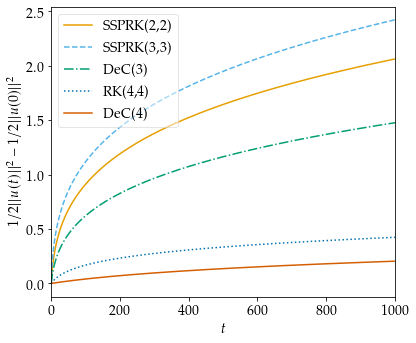

In [35]:
plt.close("all");
plt.figure(figsize=(6,5))
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=False, method="brentq", tol=1.e-15, newdt=True)
    H = [eta(uu[:,i]) for i in range(uu.shape[1])]
    plt.plot(tt, H - H[0], label=method_labels[method_idx]);

plt.legend()
plt.xlabel("$t$"); plt.ylabel("$ 1/2 ||u(t)||^2 - 1/2 ||u(0)||^2$"); plt.xlim(tt[0], tt[-1]);

plt.tight_layout()

plt.savefig("Plots/nonlinear_oscilator_normal.pdf", bbox_inches="tight")

#### Testing the relaxed methods and checking the error of the entropy

In [34]:
plt.close("all");
plt.figure(figsize=(6,5))
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    H = [eta(uu[:,i]) for i in range(uu.shape[1])]
    plt.plot(tt, H - H[0], label=method_labels[method_idx]);

plt.xlabel("$t$"); plt.ylabel("$ 1/2 ||u(t)||^2 - 1/2 ||u(0)||^2$"); plt.xlim(tt[0], tt[-1]);
plt.tight_layout()
plt.legend()
plt.savefig( "Plots/nonlinear_oscilator_relaxed.pdf", bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=6, frameon=False)
plt.savefig("Plots/nonlinear_oscilator_legend.pdf", bbox_inches="tight")

CPU times: user 259 ms, sys: 4.04 ms, total: 263 ms
Wall time: 262 ms
CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 303 ms
CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 312 ms
CPU times: user 265 ms, sys: 0 ns, total: 265 ms
Wall time: 264 ms
CPU times: user 487 ms, sys: 0 ns, total: 487 ms
Wall time: 485 ms


<Figure size 432x288 with 0 Axes>

#### Display the $\gamma_n$ coefficients in time in the relaxed algorithms

CPU times: user 249 ms, sys: 10 µs, total: 249 ms
Wall time: 248 ms
CPU times: user 283 ms, sys: 0 ns, total: 283 ms
Wall time: 283 ms
CPU times: user 299 ms, sys: 0 ns, total: 299 ms
Wall time: 298 ms
CPU times: user 254 ms, sys: 0 ns, total: 254 ms
Wall time: 253 ms
CPU times: user 472 ms, sys: 0 ns, total: 472 ms
Wall time: 471 ms


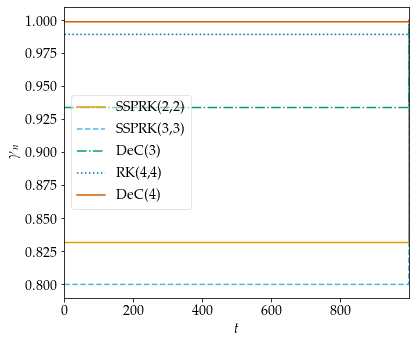

In [31]:
plt.close("all");
plt.figure(figsize=(6,5))
relaxterms = {}
relaxtt = {}
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    plt.plot(tt[1:], relax, label=method_labels[method_idx]);    
plt.xlabel("$t$");
plt.ylabel("$\gamma_n$"); 
plt.xlim(tt[0], tt[-1]);
plt.tight_layout()
plt.legend()
plt.savefig("Plots/nonlinear_oscilator_relaxterms.pdf", bbox_inches="tight")


In [ ]:
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    plt.boxplot(relax, positions=[method_idx])
plt.xticks(np.arange(len(method_labels)),method_labels, rotation=40)
plt.ylabel("$\gamma_n$"); 
plt.tight_layout()

#### Comparison of the number of timesteps of Relaxed methods

CPU times: user 908 ms, sys: 4.1 ms, total: 913 ms
Wall time: 910 ms
CPU times: user 953 ms, sys: 3.8 ms, total: 957 ms
Wall time: 955 ms
CPU times: user 978 ms, sys: 3.79 ms, total: 982 ms
Wall time: 981 ms
CPU times: user 865 ms, sys: 0 ns, total: 865 ms
Wall time: 864 ms
CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


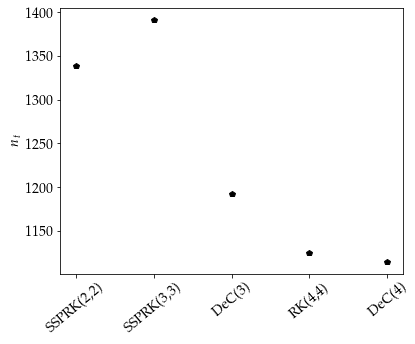

In [11]:
plt.close("all");
plt.figure(figsize=(6,5))
nsteps = []
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    nsteps.append(len(tt))
plt.plot(nsteps,"p", color="black")
plt.xticks(np.arange(len(method_labels)),method_labels, rotation=40)
plt.ylabel("$n_t$"); 
plt.tight_layout()
plt.savefig("Plots/nonlinear_oscilator_nsteps.pdf", bbox_inches="tight")


#### Checking the order of accuracy of not relaxed methods

CPU times: user 5.31 s, sys: 7.85 ms, total: 5.32 s
Wall time: 5.32 s


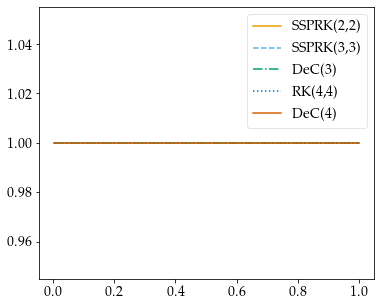

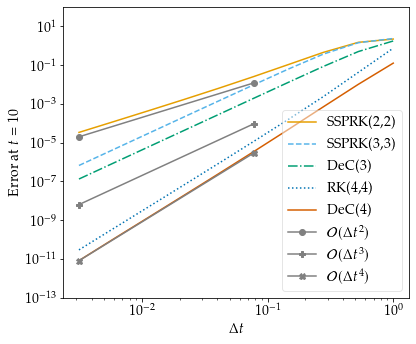

In [42]:
%%time
t_final = 10

dts = np.logspace(-2.5, 0., 10)

ylim = (1.e-13, 1.e2)

fig_conv = plt.figure("conv",figsize=(6, 5))
fig_timeteps = plt.figure("steps",figsize=(6, 5))

for method_idx in range(len(methods)):
    errors = np.zeros_like(dts)
    timesteps = np.zeros_like(dts)
    for dt_idx in range(len(dts)):
        tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dts[dt_idx], f, eta, deta, u0, t_final, 
                                    relaxed=False, method="brentq", tol=1.e-14, newdt=True, correct_last_step=False)
        errors[dt_idx] = np.linalg.norm(uu[:,-1] - u_analytical(tt[-1]))
        timesteps[dt_idx] = len(tt)
    plt.figure("conv")
    plt.plot(dts, errors, label=method_labels[method_idx]);
    plt.figure("steps")
    plt.plot(dts, relax, label=method_labels[method_idx]);
plt.legend()

plt.figure("conv")
order_dts = np.array([dts[0], dts[int(len(dts)/2)]])

plt.plot(order_dts, 2.e0 * order_dts**2, "-o", color="gray", label="$\mathcal{O}(\Delta t^2)$")
plt.plot(order_dts, 2.e-1 * order_dts**3, "-P", color="gray", label="$\mathcal{O}(\Delta t^3)$")
plt.plot(order_dts, 8.e-2 * order_dts**4, "-X", color="gray", label="$\mathcal{O}(\Delta t^4)$")

plt.xlabel("$\Delta t$"); plt.ylabel("Error at $t = %.0f$"%t_final)
plt.xscale("log"); plt.yscale("log")
plt.ylim(ylim)
plt.tight_layout()
plt.legend()
plt.savefig("Plots/nonlinosc_conv_normal.pdf", bbox_inches="tight")


#### Checking the order of relaxed methods

CPU times: user 1.54 s, sys: 24 ms, total: 1.57 s
Wall time: 1.96 s


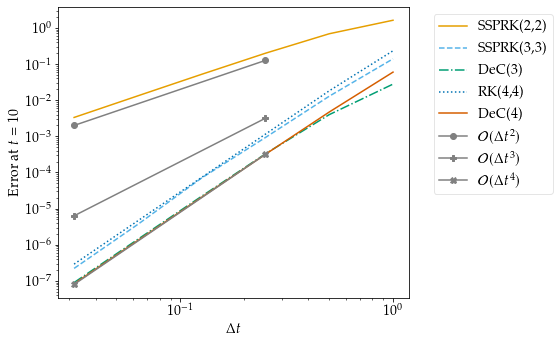

In [59]:
%%time

fig_conv = plt.figure("conv",figsize=(6, 5))
                                           
for method_idx in range(len(methods)):
    errors = np.zeros_like(dts)
    timesteps = []
    for dt_idx in range(len(dts)):
        tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dts[dt_idx], f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-14, newdt=True, correct_last_step=False)
        errors[dt_idx] = np.linalg.norm(uu[:,-1] - u_analytical(tt[-1]))
        timesteps.append(len(tt))
    plt.figure("conv")
    plt.plot(dts, errors, label=method_labels[method_idx]);
    
order_dts = np.array([dts[0], dts[int(len(dts)/2)]])

plt.plot(order_dts, 2.e0 * order_dts**2, "-o", color="gray", label="$\mathcal{O}(\Delta t^2)$")
plt.plot(order_dts, 2.e-1 * order_dts**3, "-P", color="gray", label="$\mathcal{O}(\Delta t^3)$")
plt.plot(order_dts, 8.e-2 * order_dts**4, "-X", color="gray", label="$\mathcal{O}(\Delta t^4)$")

plt.xlabel("$\Delta t$"); plt.ylabel("Error at $t = %.0f$"%t_final)
plt.xscale("log"); plt.yscale("log")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Plots/nonlinosc_conv_relaxed.pdf", bbox_inches="tight")
                                           


CPU times: user 3.61 s, sys: 16 ms, total: 3.62 s
Wall time: 3.99 s


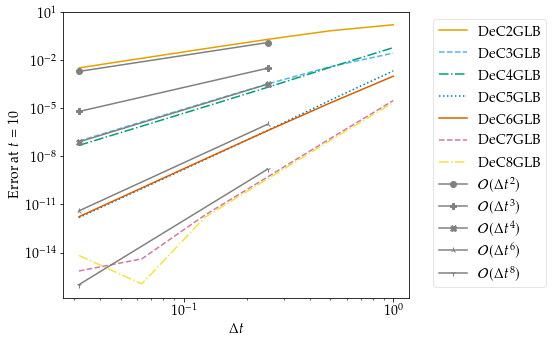

In [57]:
%%time

dts = np.logspace(-1.5, 0., 6)

fig_conv = plt.figure("conv",figsize=(6, 5))
                                           
for order in range(2,9):
    method=decGLBRKs[order-2]
    errors = np.zeros_like(dts)
    timesteps = []
    for dt_idx in range(len(dts)):
        tt, uu, relax = convex_relaxed_ERK(method, dts[dt_idx], f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-14, newdt=True, correct_last_step=False)
        errors[dt_idx] = np.linalg.norm(uu[:,-1] - u_analytical(tt[-1]))
        timesteps.append(len(tt))
    plt.figure("conv")
    plt.plot(dts, errors, label=method.name);
    
order_dts = np.array([dts[0], dts[int(len(dts)/2)]])

plt.plot(order_dts, 2.e0 * order_dts**2, "-o", color="gray", label="$\mathcal{O}(\Delta t^2)$")
plt.plot(order_dts, 2.e-1 * order_dts**3, "-P", color="gray", label="$\mathcal{O}(\Delta t^3)$")
plt.plot(order_dts, 8.e-2 * order_dts**4, "-X", color="gray", label="$\mathcal{O}(\Delta t^4)$")
plt.plot(order_dts, 4.e-3 * order_dts**6, "-2", color="gray", label="$\mathcal{O}(\Delta t^6)$")
plt.plot(order_dts, 1.e-4 * order_dts**8, "-1", color="gray", label="$\mathcal{O}(\Delta t^8)$")

plt.xlabel("$\Delta t$"); plt.ylabel("Error at $t = %.0f$"%t_final)
plt.xscale("log"); plt.yscale("log")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Plots/nonlinosc_conv_GLBDeC_relaxed.pdf", bbox_inches="tight")
                                           


CPU times: user 6.88 s, sys: 36 ms, total: 6.91 s
Wall time: 7.15 s


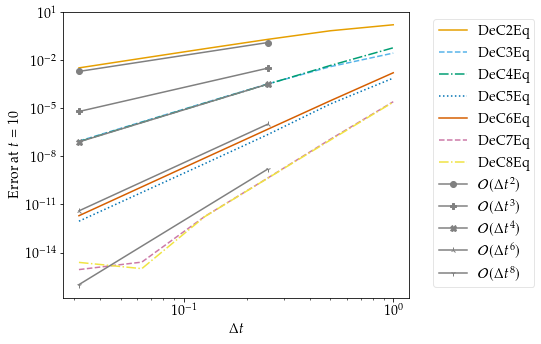

In [56]:
%%time

dts = np.logspace(-1.5, 0., 6)

fig_conv = plt.figure("conv",figsize=(6, 5))
                                           
for order in range(2,9):
    method=decEqRKs[order-2]
    errors = np.zeros_like(dts)
    timesteps = []
    for dt_idx in range(len(dts)):
        tt, uu, relax = convex_relaxed_ERK(method, dts[dt_idx], f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-14, newdt=True, correct_last_step=False)
        errors[dt_idx] = np.linalg.norm(uu[:,-1] - u_analytical(tt[-1]))
        timesteps.append(len(tt))
    plt.figure("conv")
    plt.plot(dts, errors, label=method.name);
    
order_dts = np.array([dts[0], dts[int(len(dts)/2)]])

plt.plot(order_dts, 2.e0 * order_dts**2, "-o", color="gray", label="$\mathcal{O}(\Delta t^2)$")
plt.plot(order_dts, 2.e-1 * order_dts**3, "-P", color="gray", label="$\mathcal{O}(\Delta t^3)$")
plt.plot(order_dts, 8.e-2 * order_dts**4, "-X", color="gray", label="$\mathcal{O}(\Delta t^4)$")
plt.plot(order_dts, 4.e-3 * order_dts**6, "-2", color="gray", label="$\mathcal{O}(\Delta t^6)$")
plt.plot(order_dts, 1.e-4 * order_dts**8, "-1", color="gray", label="$\mathcal{O}(\Delta t^8)$")

plt.xlabel("$\Delta t$"); plt.ylabel("Error at $t = %.0f$"%t_final)
plt.xscale("log"); plt.yscale("log")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Plots/nonlinosc_conv_EqDeC_relaxed.pdf", bbox_inches="tight")
                                           


# Dissipated Exponential Entropy

In [60]:
def f(w):
    return np.array([-np.exp(w[0]), -np.exp(w[1])])

def eta(w):
    return np.exp(w[0]) + np.exp(w[1])

def deta(w):
    return np.array([np.exp(w[0]), np.exp(w[1])])

def u_analytical(t):
    w0 = -np.log(1 / np.e + t)
    w1 = -np.log(1/np.sqrt(np.e) + t)
    return np.array([w0, w1])

u0 = [1.0, 0.5]

dt = 0.1
t_final = 5

CPU times: user 31.8 s, sys: 3.58 ms, total: 31.8 s
Wall time: 31.8 s


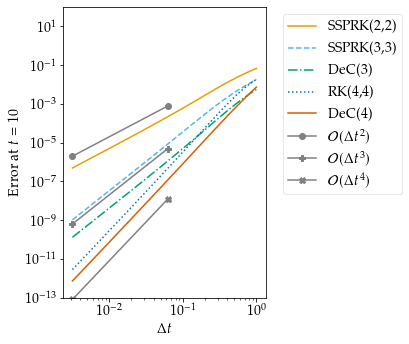

<Figure size 432x288 with 0 Axes>

In [64]:
%%time
t_final = 10

dts = np.logspace(-2.5, 0., 30)

ylim = (1.e-13, 1.e2)

fig_conv = plt.figure("conv",figsize=(6, 5))

for method_idx in range(len(methods)):
    errors = np.zeros_like(dts)
    timesteps = np.zeros_like(dts)
    for dt_idx in range(len(dts)):
        tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dts[dt_idx], f, eta, deta, u0, t_final, 
                                    relaxed=True, method="brentq", tol=1.e-14, newdt=True, correct_last_step=False)
        errors[dt_idx] = np.linalg.norm(uu[:,-1] - u_analytical(tt[-1]))
        timesteps[dt_idx] = len(tt)
    plt.figure("conv")
    plt.plot(dts, errors, label=method_labels[method_idx]);

plt.figure("conv")
order_dts = np.array([dts[0], dts[int(len(dts)/2)]])

plt.plot(order_dts, 2.e-1 * order_dts**2, "-o", color="gray", label="$\mathcal{O}(\Delta t^2)$")
plt.plot(order_dts, 2.e-2 * order_dts**3, "-P", color="gray", label="$\mathcal{O}(\Delta t^3)$")
plt.plot(order_dts, 8.e-4 * order_dts**4, "-X", color="gray", label="$\mathcal{O}(\Delta t^4)$")

plt.xlabel("$\Delta t$"); plt.ylabel("Error at $t = %.0f$"%t_final)
plt.xscale("log"); plt.yscale("log")
plt.ylim(ylim)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=6, frameon=False)


# Nonlinear Pendulum

In [68]:
def f(w):
    return np.array([-np.sin(w[1]), w[0]])

def eta(w):
    return 0.5*w[0]**2 - np.cos(w[1])

def deta(w):
    return np.array([w[0], np.sin(w[1])])

u0 = [1.5, 0]

dt = 0.9
t_final = 1000


### Energy Evolution

##### Classical methods

CPU times: user 1.06 s, sys: 8 ms, total: 1.07 s
Wall time: 1.08 s


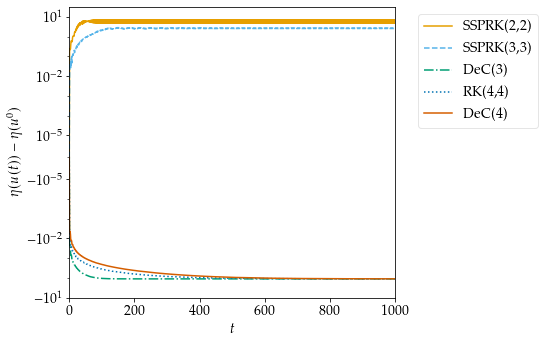

<Figure size 432x288 with 0 Axes>

In [69]:
%%time

plt.figure(figsize=(6, 5))
for method_idx in range(len(methods)):
    tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, 
                                relaxed=False, method="brentq", tol=1.e-15, newdt=True)
    H = [eta(uu[:,i]) for i in range(uu.shape[1])]
    plt.plot(tt, H - H[0], label=method_labels[method_idx]);

plt.xlabel("$t$"); plt.ylabel("$\eta(u(t)) - \eta(u^0)$"); plt.xlim(tt[0], tt[-1]);
plt.yscale("symlog", linthresh=1.e-5)
#plt.locator_params(axis='y', numticks=6)
plt.yticks([-1.e1, -1.e-2, -1.e-5, 1.e-5, 1.e-2, 1.e1])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Plots/pendulum__energy_standard.pdf", bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=6, frameon=False)
plt.savefig("Plots/pendulum__energy_legend.pdf", bbox_inches="tight")

##### Relaxed methods

CPU times: user 1.9 s, sys: 12 ms, total: 1.91 s
Wall time: 1.92 s


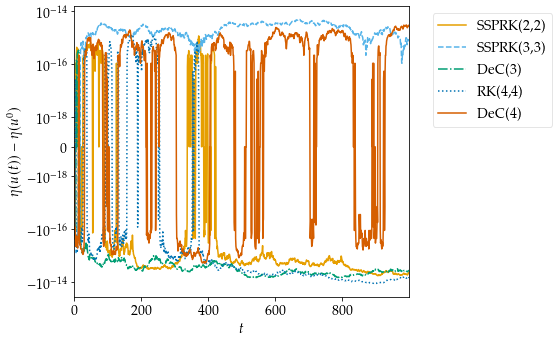

In [70]:
%%time

plt.figure(figsize=(6, 5))
for method_idx in range(len(methods)):
    tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, 
                                relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    H = [eta(uu[:,i]) for i in range(uu.shape[1])]
    plt.plot(tt, H - H[0], label=method_labels[method_idx]);

plt.xlabel("$t$"); plt.ylabel("$\eta(u(t)) - \eta(u^0)$"); plt.xlim(tt[0], tt[-1]);
plt.yscale("symlog", linthresh=1.e-18)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Plots/pendulum__energy_relaxed.pdf", bbox_inches="tight")

#### Distribution of $\gamma_n$ during the method and number of timesteps

CPU times: user 278 ms, sys: 13 µs, total: 278 ms
Wall time: 277 ms
CPU times: user 256 ms, sys: 0 ns, total: 256 ms
Wall time: 256 ms
CPU times: user 299 ms, sys: 4 µs, total: 299 ms
Wall time: 299 ms
CPU times: user 275 ms, sys: 2 µs, total: 275 ms
Wall time: 274 ms
CPU times: user 497 ms, sys: 0 ns, total: 497 ms
Wall time: 496 ms


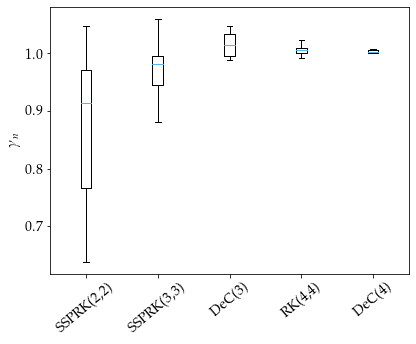

In [72]:
plt.close("all");
plt.figure(figsize=(6,5))
nsteps = []
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    plt.boxplot(relax, positions=[method_idx])
plt.xticks(np.arange(len(method_labels)),method_labels, rotation=40)
plt.ylabel("$\gamma_n$"); 
plt.tight_layout()
plt.savefig("Plots/pendulum_relaxterms.pdf", bbox_inches="tight")


CPU times: user 277 ms, sys: 4 µs, total: 277 ms
Wall time: 276 ms
CPU times: user 261 ms, sys: 8 µs, total: 261 ms
Wall time: 260 ms
CPU times: user 322 ms, sys: 9 µs, total: 322 ms
Wall time: 321 ms
CPU times: user 281 ms, sys: 5 µs, total: 281 ms
Wall time: 280 ms
CPU times: user 544 ms, sys: 0 ns, total: 544 ms
Wall time: 543 ms


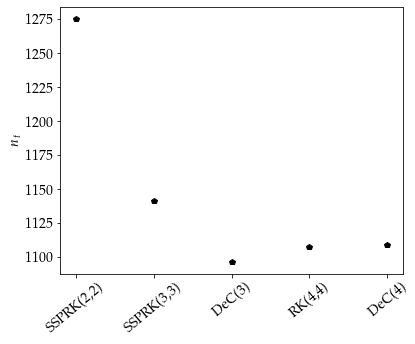

In [73]:
plt.close("all");
plt.figure(figsize=(6,5))
nsteps = []
for method_idx in range(len(methods)):
    %time tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, relaxed=True, method="brentq", tol=1.e-15, newdt=True)
    nsteps.append(len(tt))
plt.plot(nsteps,"p", color="black")
plt.xticks(np.arange(len(method_labels)),method_labels, rotation=40)
plt.ylabel("$n_t$"); 
plt.tight_layout()
plt.savefig("Plots/pendulum_nsteps.pdf", bbox_inches="tight")


### Phase Space and Energy

CPU times: user 1.02 s, sys: 3.99 ms, total: 1.03 s
Wall time: 1.03 s


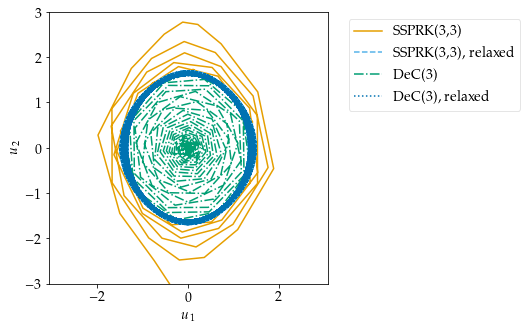

<Figure size 432x288 with 0 Axes>

In [74]:
%%time

fig_energy = plt.figure("phase", figsize=(5, 5))

for method_idx in [1,2]:
    for relaxed in [False, True]:
        tt, uu, relax = convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, 
                                    relaxed=relaxed, method="brentq", tol=1.e-15, newdt=True)

        plt.figure("phase")

        label = method_labels[method_idx]
        if relaxed:
            label = "%s, relaxed"%label
        plt.plot(uu[0],uu[1], label=label);

plt.figure("phase")
plt.axis('equal')
plt.xlabel("$u_1$"); plt.ylabel("$u_2$");
amplitude = 3.0; plt.xlim((-amplitude, amplitude)); plt.ylim((-amplitude, amplitude));
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("Plots/pendulum__phase_phase.pdf", bbox_inches="tight")

ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=6, frameon=False)
plt.savefig("Plots/pendulum__phase_legend.pdf", bbox_inches="tight")

# Burgers' Equation with Energy

In [100]:
plt.rc("font", size=16)
convex_relaxed_ERK(methods[method_idx], dt, f, eta, deta, u0, t_final, 
                                    relaxed=relaxed, method="brentq", tol=1.e-15, newdt=True)

def burgers_energy(rkms, tfinal=0.02, relaxation=True, eps=0., cflnum=0.1, plotabs=True, plot_exact=False):
    x = np.linspace(-1,1,50)
    dx = x[1]-x[0]
    u0 = np.exp(-30*x**2)

    def f(u):
        Fiph = np.zeros_like(u)
        fluxdiff = np.zeros_like(u)
        Fiph[:-1] = (u[1:]**2 + u[1:]*u[:-1] + u[:-1]**2) - eps*(u[1:]-u[:-1])  # Entropy dissipative
        fluxdiff[1:] = -(Fiph[1:]-Fiph[:-1])/dx
        return fluxdiff
    def eta(u):
        return 0.5*sum(u**2.) * dx

    def deta(u):
        return u * dx
    dt = cflnum*dx
    
    for rkm in rkms:
        if relaxation:
            tt, uu, relax = convex_relaxed_ERK(rkm, dt,f, eta, deta, u0, tfinal, relaxed=True, method="brentq", tol = 1e-15, newdt=True)
        else:
            tt, uu, relax = convex_relaxed_ERK(rkm, dt,f, eta, deta, u0, tfinal, relaxed=False, method="brentq", tol = 1e-15, newdt=True)

        E = [sum(uu[:,i]**2) for i in range(uu.shape[1])]
        if plotabs:
            plt.semilogy(tt[1:],np.abs(E[1:]-E[0]),lw=3, label=rkm.name);
            plt.ylabel('$|\|u^{n}\|^2 - \|u^{0}\|^2|$'); plt.xlabel('$t$')
        else:
            plt.plot(tt[1:],(E[1:]-E[0])/E[0],lw=3,label=rkm.name);
            plt.ylabel('$(\|u^{n}\|^2 - \|u^{0}\|^2)/\|u^{0}\|^2$'); plt.xlabel('$t$')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Energy error with classical methods 

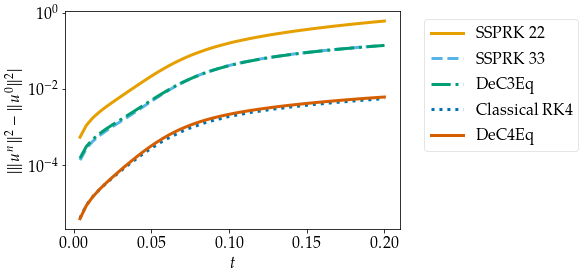

In [103]:
burgers_energy(methods,tfinal=0.2,relaxation=False,cflnum=0.1, eps=0.,plot_exact=True)
plt.savefig('Plots/burgers_energy_rk.pdf', bbox_inches="tight")

#### Energy error with relaxed methods

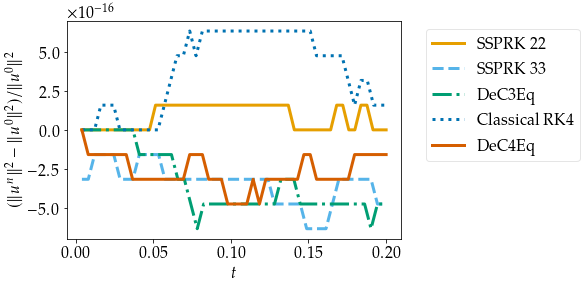

In [102]:
burgers_energy(methods,tfinal=0.2,relaxation=True,cflnum=0.1,plotabs=False)
plt.savefig('Plots/burgers_energy_rrk.pdf', bbox_inches="tight")